In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd\
    .read_parquet('./../data/sales.parquet')\
    .query("ESTADO != 'Indefinido' & PRODUTO != 'Indefinido' & CATEGORIA != 'Indefinido'")
df.head()

,CLIENTE,IDADE,ESTADO,PRODUTO,QUANTIDADE_VENDIDA,PREÇO_UNITARIO,DATA,CATEGORIA,FATURAMENTO,ANO,MES,DIA,FAIXA_ETARIA
0,9010,72.0,SANTA CATARINA,E,243,50,2024-10-26,JARDINAGEM,12150,2024,10,26,55+
1,63611,46.0,PARANÁ,B,320,15,2024-12-27,MANGUEIRAS,4800,2024,12,27,45–54
2,56708,67.0,BAHIA,D,143,30,2023-06-30,LIMPEZA,4290,2023,6,30,55+
3,3924,46.0,SÃO PAULO,B,295,15,2025-06-02,MANGUEIRAS,4425,2025,6,2,45–54
4,47317,53.0,RIO DE JANEIRO,C,203,45,2025-02-15,UTILIDADES DOMÉSTICAS,9135,2025,2,15,45–54


# 1) Perfil demográfico dos clientes

In [3]:
df['IDADE'].describe()

count    499082.000000
mean         39.183811
std          11.558920
min          18.000000
25%          31.000000
50%          39.000000
75%          47.000000
max          80.000000
Name: IDADE, dtype: float64

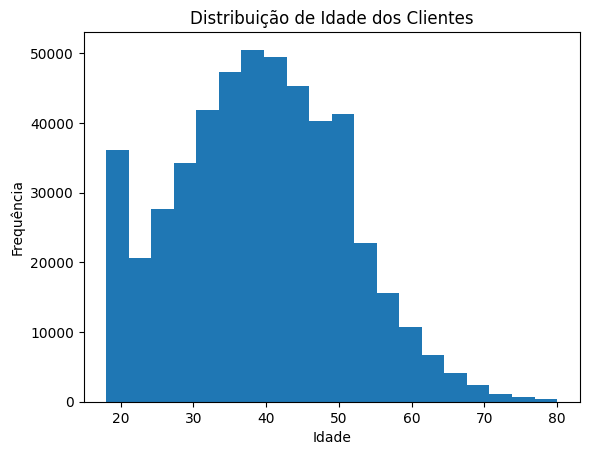

In [4]:
plt.figure()
plt.hist(df['IDADE'].dropna(), bins=20)
plt.title('Distribuição de Idade dos Clientes')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.show()

In [5]:
dist_state = df\
    .groupby('ESTADO')['CLIENTE']\
    .count()\
    .sort_values(ascending=False)
dist_state

ESTADO
SÃO PAULO            161089
RIO DE JANEIRO        89064
PARANÁ                69811
BAHIA                 59321
RIO GRANDE DO SUL     50042
SANTA CATARINA        49930
PARAÍBA               19825
Name: CLIENTE, dtype: int64

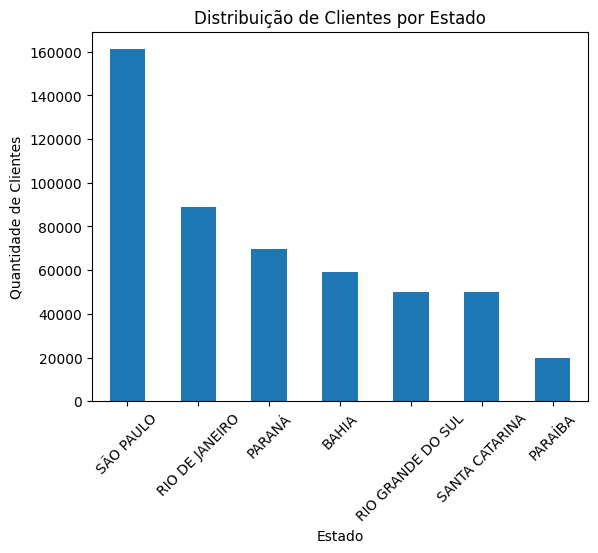

In [16]:
plt.figure()
dist_state.plot(kind='bar')
plt.title('Distribuição de Clientes por Estado')
plt.xlabel('Estado')
plt.ylabel('Quantidade de Clientes')
plt.xticks(rotation=45)
plt.show()

# 2) Performance por categoria de produto

In [19]:
categories = df\
    .groupby('CATEGORIA')\
    .agg(
        volume=('QUANTIDADE_VENDIDA', 'sum'),
        faturamento=('FATURAMENTO', 'sum')
    )\
    .sort_values('faturamento', ascending=False)
categories

,volume,faturamento
CATEGORIA,,
JARDINAGEM,20016639,1000831950
UTILIDADES DOMÉSTICAS,20364587,916406415
LIMPEZA,16146075,484382250
MANGUEIRAS,29772414,446586210
MAQUINA DE CORTAR GRAMA,6492790,162319750


In [20]:
df\
    .groupby('CATEGORIA')['FATURAMENTO']\
    .mean()\
    .round(2)\
    .sort_values(ascending=False)
    

CATEGORIA
JARDINAGEM                 10047.40
UTILIDADES DOMÉSTICAS       9139.84
LIMPEZA                     4849.54
MANGUEIRAS                  4491.37
MAQUINA DE CORTAR GRAMA     1624.95
Name: FATURAMENTO, dtype: float64

# 3) Sazonalidade

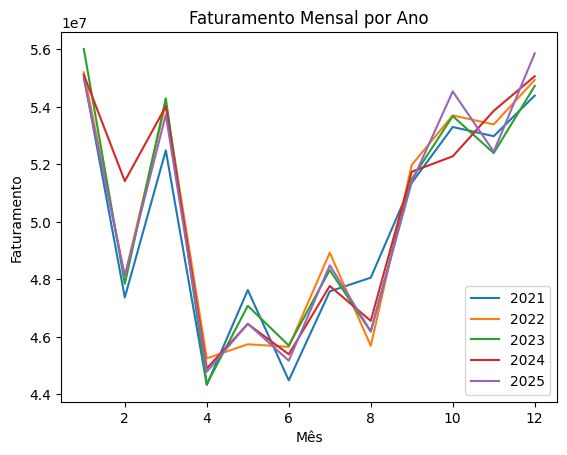

In [9]:
years = sorted(df['ANO'].unique())

plt.figure()
for y in years:
    df_year = df[df['ANO'] == y]
    sales_month = df_year.groupby('MES')['FATURAMENTO'].sum()
    plt.plot(sales_month.index, sales_month.values, label=str(y))

plt.title('Faturamento Mensal por Ano')
plt.xlabel('Mês')
plt.ylabel('Faturamento')
plt.legend()
plt.show()

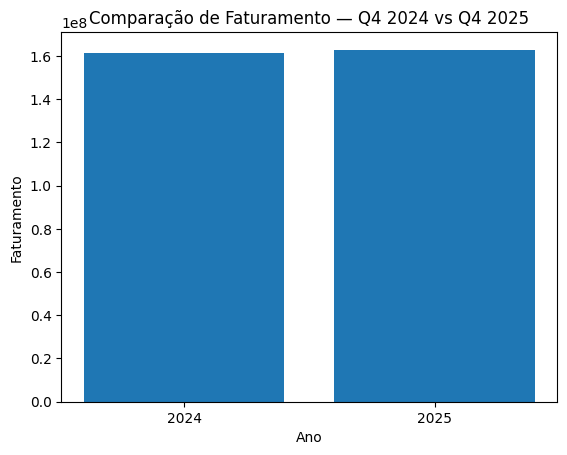

In [10]:
df['TRIMESTRE'] = df['DATA'].dt.quarter

df_q4 = df[
    (df['TRIMESTRE'] == 4) &
    (df['ANO'].isin([2024, 2025]))
]

sales_q4 = (
    df_q4
    .groupby('ANO')['FATURAMENTO']
    .sum()
    .reset_index()
)

plt.figure()
plt.bar(sales_q4['ANO'], sales_q4['FATURAMENTO'])

plt.xticks(sales_q4['ANO'], sales_q4['ANO'].astype(int))
plt.title('Comparação de Faturamento — Q4 2024 vs Q4 2025')
plt.xlabel('Ano')
plt.ylabel('Faturamento')
plt.show()

# 4) Tendência de vendas por região

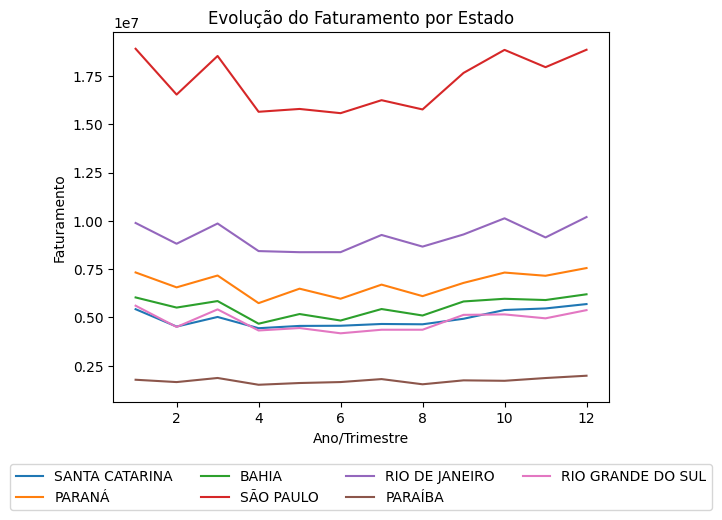

In [ ]:
region = df\
    .query('ANO >= 2025')\
    .groupby(['MES', 'ESTADO'])['FATURAMENTO']\
    .sum()\
    .reset_index()

plt.figure()
for state in df['ESTADO'].unique():
    data = region[region['ESTADO'] == state]
    plt.plot(
        data['MES'],
        data['FATURAMENTO'],
        label=state
    )

plt.title('Evolução do Faturamento por Estado')
plt.xlabel('Mês')
plt.ylabel('Faturamento')
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=4
)

plt.show()

In [24]:
regions = df\
    .groupby('ESTADO')\
    .agg(
        faturamento=('FATURAMENTO', 'sum'),
        volume=('QUANTIDADE_VENDIDA', 'sum'),
        ticket_medio=('FATURAMENTO', 'mean')
    )\
    .sort_values(ascending=False, by='faturamento')
regions

,faturamento,volume,ticket_medio
ESTADO,,,
SÃO PAULO,1030409250,31810340,6396.521488
RIO DE JANEIRO,551160170,16986732,6188.360842
PARANÁ,407618085,12560755,5838.880477
BAHIA,331844675,10254407,5594.050589
SANTA CATARINA,296157905,9088191,5931.462147
RIO GRANDE DO SUL,287995370,8845695,5755.073139
PARAÍBA,105341120,3246385,5313.549559


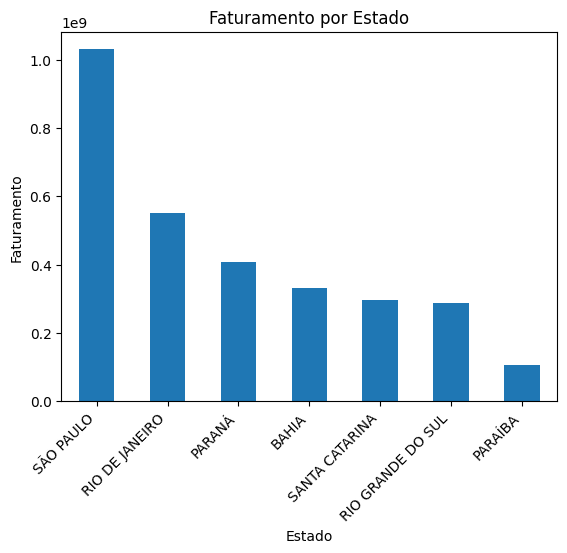

In [25]:
plt.figure()
regions['faturamento'].plot(kind='bar')
plt.title('Faturamento por Estado')
plt.xlabel('Estado')
plt.ylabel('Faturamento')
plt.xticks(rotation=45, ha='right')
plt.show()

# 5) Relação entre idade e categorias compradas

/tmp/ipykernel_14573/3682806667.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df.pivot_table(


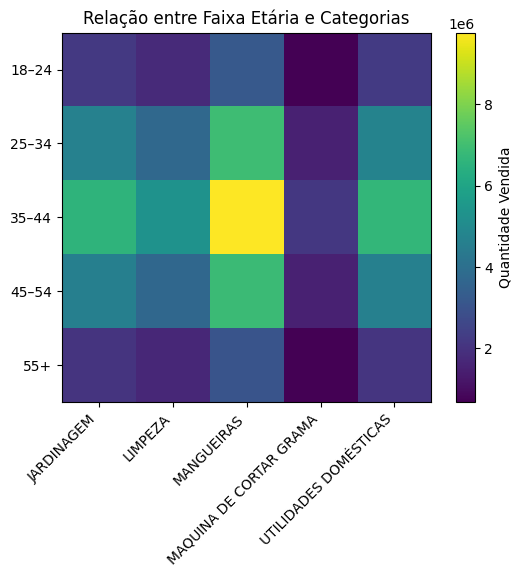

In [26]:
heatmap_data = (
    df.pivot_table(
        values='QUANTIDADE_VENDIDA',
        index='FAIXA_ETARIA',
        columns='CATEGORIA',
        aggfunc='sum',
        fill_value=0
    )
)

plt.figure()
plt.imshow(heatmap_data.values)
plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns, rotation=90)
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)
plt.colorbar(label='Quantidade Vendida')
plt.title('Relação entre Faixa Etária e Categorias')
plt.xticks(rotation=45, ha='right')
plt.show()

In [15]:
commons = heatmap_data.idxmax(axis=1)
commons

FAIXA_ETARIA
18–24    MANGUEIRAS
25–34    MANGUEIRAS
35–44    MANGUEIRAS
45–54    MANGUEIRAS
55+      MANGUEIRAS
dtype: object